In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
#import seaborn as sns
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from sklearn.linear_model import LinearRegression
import tensorflow.compat.v1 as tf
from numba import cuda
from tqdm import notebook
from adan_utils import get_batches, vaf

In [ ]:
%%bash

cd ../slurm/
sbatch ../sweep_scripts/batchSweep_ADAN.sh

WilcoxonResult(statistic=6.0, pvalue=1.4522080830746074e-13)
Mean improvement:  0.23245015470107597


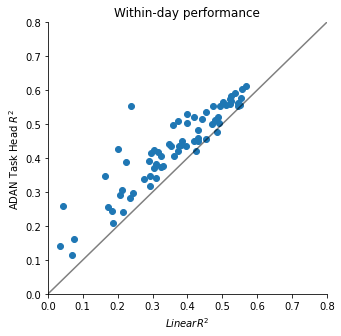

In [16]:
fig_path   = '/home/users/ghwilson/projects/nonstationarities/figures/'
scores_dir = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/ADAN/models/scores/'


scores = np.concatenate([np.load(f) for f in glob.glob(f'{scores_dir}*.npy')])

figSize(5, 5)

plt.scatter(scores[:, 1], scores[:, 0])
plt.xlim([0, 0.8])
plt.ylim([0, 0.8])
plt.plot([0, 0.8], [0, 0.8], color =  'k', alpha = 0.5)
plt.xlabel('$Linear R^{2}$')
plt.ylabel('ADAN Task Head $R^{2}$')
plt.title('Within-day performance')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print(scipy.stats.wilcoxon(scores[:, 0], scores[:, 1]))
print('Mean improvement: ', np.mean((scores[:, 0] - scores[:, 1]) / scores[:, 1]))

plt.savefig(os.path.join(fig_path, 'ADAN', 'withinday_scores.pdf'))
plt.show()

In [5]:
from CosineTuning import getAngles
from adan_utils import train_ADAN


    
    


def test_ADAN(arg, model_folder):
    '''Test subspace stabilizer using generated session pairs dataset. Input <arg> is 
       dictionary with key-value pairs: '''
    

    # load tf model file (use /session_pairs/ bc pickled files have compatible sklearn models)
    model_date  = re.search(r'(\d+.\d+.\d+)', arg['file']).group(0)
    model_dir   = os.path.join(model_folder, model_date)
    tf.reset_default_graph()


    # load pickled data
    arg['file'] = arg['file'].replace('/train/', '/session_pairs/')
    pair_data   = np.load(arg['file'], allow_pickle = True).item()
    pair_data.keys()

    spike_day0 = np.concatenate([pair_data['A_train_neural'], pair_data['A_test_neural']])
    spike_dayk = pair_data['B_train_neural']
    spike_test = pair_data['B_test_neural']

    emg_day0 = np.concatenate([pair_data['A_train_targvec'], pair_data['A_test_targvec']])
    emg_dayk = pair_data['B_train_targvec']
    emg_test = pair_data['B_test_targvec']
    
    emg_test_aligned = train_ADAN(arg, model_dir, spike_day0, emg_day0, spike_dayk, emg_dayk, spike_test)
                  
    score_dict = dict(arg)
    score_dict['R2_score']   = sklearn.metrics.r2_score(emg_test,emg_test_aligned)                         
    score_dict['pearson_r']  = np.corrcoef(emg_test.flatten(), emg_test_aligned.flatten())[0, 1]                    
    score_dict['days_apart'] = pair_data['days_apart']
    
    # no recalibration whatsoever
    score_dict['norecal_R2_score']  = pair_data['norecal_R2_score']
    score_dict['norecal_pearson_r'] = pair_data['norecal_pearson_r']
    
    # mean recalibration only 
    score_dict['meanrecal_R2_score'] = pair_data['meanrecal_R2_score']      
    score_dict['meanrecal_pearson_r']= pair_data['meanrecal_pearson_r'] 
    
    # full supervised recalibration 
    score_dict['suprecal_R2_score']  = pair_data['suprecal_R2_score']
    score_dict['suprecal_pearson_r'] = pair_data['suprecal_pearson_r']

    return score_dict



'''
def test_ADAN(arg, model_folder):
      # Test subspace stabilizer using generated session pairs dataset. Input <arg> is 
      # dictionary with key-value pairs: 
    

    # load tf model file (use /session_pairs/ bc pickled files have compatible sklearn models)
    model_date  = re.search(r'(\d+.\d+.\d+)', arg['file']).group(0)
    model_dir   = os.path.join(model_folder, model_date)
    tf.reset_default_graph()

    g       = tf.train.import_meta_graph(os.path.join(model_dir, 'decoder.meta'))
    graph   = tf.get_default_graph()
    spike   = graph.get_tensor_by_name("spike:0")
    emg_hat =  graph.get_tensor_by_name(name="emg_hat:0")

    input_day0 = tf.placeholder(tf.float32, (None, arg['spike_dim']), name='input_day0')
    input_dayk = tf.placeholder(tf.float32, (None, arg['spike_dim']), name='input_dayk')

    # load pickled data
    arg['file'] = arg['file'].replace('/train/', '/session_pairs/')
    pair_data   = np.load(arg['file'], allow_pickle = True).item()
    pair_data.keys()

    spike_day0 = np.concatenate([pair_data['A_train_neural'], pair_data['A_test_neural']])
    
    #plt.plot(spike_day0[:500, :10])
    #assert False
    spike_dayk = pair_data['B_train_neural']
    spike_test = pair_data['B_test_neural']

    #spike_day0 /= np.std(spike_day0, axis = 0, keepdims = True)
    #spike_dayk /= np.std(spike_day0, axis = 0, keepdims = True)

    emg_day0 = np.concatenate([pair_data['A_train_targvec'], pair_data['A_test_targvec']])
    emg_dayk = pair_data['B_train_targvec']
    emg_test = pair_data['B_test_targvec']

    
    def generator(input_, reuse=False):
        with tf.variable_scope('generator',initializer=tf.initializers.identity(),reuse=reuse):
            h1 = tf.layers.dense(input_,  arg['spike_dim'], activation=tf.nn.elu)
            output  = tf.layers.dense(h1, arg['spike_dim'], activation=None)
        return output

    def discriminator(input_, n_units=[64,32, arg['latent_dim']], reuse=False):
        with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
            noise = tf.random_normal(tf.shape(input_), dtype=tf.float32) * 50
            input_ = input_+noise
            h1 = tf.layers.dense(input_, units=n_units[0], activation=tf.nn.elu)
            h2 = tf.layers.dense(h1, units=n_units[1], activation=tf.nn.elu)
            latent = tf.layers.dense(h2, units=n_units[2], activation=None)
            h3 = tf.layers.dense(latent, units=n_units[1], activation=tf.nn.elu)
            h4 = tf.layers.dense(h3, units=n_units[0], activation=tf.nn.elu)
            logits = tf.layers.dense(h4, units=arg['spike_dim'], activation=None)
            return latent, logits


    # setup generator and discriminator, as well as loss fcns
    input_dayk_aligned      = generator(input_dayk)
    latent_day0,logits_day0 = discriminator(input_day0)
    latent_dayk,logits_dayk = discriminator(input_dayk_aligned)
    
    # set up PRIT and get initial outputs
    X_min, X_max, Y_min, Y_max = pair_data['B_screenBounds']
    X_loc,Y_loc                = np.meshgrid(np.linspace(X_min, X_max, arg['gridSize']), 
                                             np.linspace(Y_min, Y_max, arg['gridSize']))
    targLocs                   = np.vstack([np.ravel(X_loc), np.ravel(Y_loc[:])]).T
    
    HMM = HMMRecalibration(arg['stateTrans'], targLocs, arg['pStateStart'], arg['kappa'], 
                                 adjustKappa = lambda dist : 1 / (1 + np.exp(-1 * (dist - arg['inflection']) *arg['exp'])))
       
    print(pair_data.keys())
        
        
    train_cursorPos = np.vstack(pair_data['B_train_cursor'])
    
    with tf.Session().as_default():
        rawDecTraj      = emg_hat.eval(feed_dict={spike:spike_dayk})

    targStates, vp  = hmm.viterbi_search(rawDecTraj, train_cursorPos, clickSignal = None)
    pTargState, _   = hmm.decode(rawDecTraj, train_cursorPos, clickSignal = None)

    maxProb         = np.max(pTargState, axis = 0)              
    inferredTargLoc = hmm.targLocs[targStates.astype('int').flatten(), :] # predicted target locations at each timepoint
    inferredPosErr  = inferredTargLoc - train_cursorPos                   # generate inferred cursorErr signals
    inferredPosErr  = np.multiply(inferredPosErr, maxProb)
    
    return np.corrcoef(inferredTargLoc.T, pair_data['B_train_targetPos'].T)


    d_loss_0 = tf.reduce_mean(tf.abs(logits_day0-input_day0)) 
    d_loss_k = tf.reduce_mean(tf.abs(logits_dayk-input_dayk_aligned))
    d_loss = d_loss_0 - d_loss_k
    g_loss = d_loss_k
    
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_opt = tf.train.AdamOptimizer(learning_rate=arg['d_lr']).minimize(d_loss, var_list=d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate=arg['g_lr']).minimize(g_loss, var_list=g_vars)
    
    
    n_batches  = min(len(spike_day0),len(spike_dayk))//(arg['batch_size'])
    a_vars     = [var.name for var in t_vars if var.name.startswith('autoencoder')]
    for i,name in enumerate(a_vars):
        tf.train.init_from_checkpoint(os.path.join(model_dir, ''), {name[:-2]:d_vars[i]})

    init = tf.global_variables_initializer()

    with tf.Session() as sess: 
        init.run()
        g.restore(sess, tf.train.latest_checkpoint(os.path.join(model_dir, '')))
        for epoch in notebook.tqdm(range(arg['n_epochs'])):
            spike_0_gen_obj = get_batches(spike_day0, arg['batch_size'])
            spike_k_gen_obj = get_batches(spike_dayk, arg['batch_size'])

            for ii in range(n_batches):
                spike_0_batch = next(spike_0_gen_obj)
                spike_k_batch = next(spike_k_gen_obj)
                sys.stdout.flush()
                _,g_loss_ = sess.run([g_opt,g_loss],feed_dict={input_day0:spike_0_batch,input_dayk:spike_k_batch})
                _,d_loss_0_,d_loss_k_ = sess.run([d_opt,d_loss_0,d_loss_k],feed_dict={input_day0:spike_0_batch,input_dayk:spike_k_batch})

            if (epoch % arg['print_every'] == 0) or (epoch == arg['n_epochs']-1):
                print("\r{}".format(epoch), "Discriminator loss_day_0:",d_loss_0_,"\Discriminator loss_day_k:",d_loss_k_)
                input_dayk_aligned_ = input_dayk_aligned.eval(feed_dict={input_dayk:spike_dayk})
                emg_dayk_aligned    = emg_hat.eval(feed_dict={spike:input_dayk_aligned_})
                emg_k_              = emg_hat.eval(feed_dict={spike:spike_dayk})
                print("EMG non-aligned VAF:", vaf(emg_dayk,emg_k_),
                      "\tEMG aligned VAF:", vaf(emg_dayk,emg_dayk_aligned),
                     "\tEMG aligned r: ", np.corrcoef(emg_dayk.flatten(), emg_dayk_aligned.flatten())[0, 1])
                
                plt.figure()
                plt.plot(emg_dayk[500:1000, :] + np.asarray([0, 400]), color = 'k')
                plt.plot(emg_dayk_aligned[500:1000, :] + np.asarray([0, 400]), color = 'r' )
                plt.show()
                
        input_test_aligned_ = input_dayk_aligned.eval(feed_dict={input_dayk:spike_test})
        emg_test_aligned    = emg_hat.eval(feed_dict={spike:input_test_aligned_})
                  
    score_dict = dict(arg)
    score_dict['R2_score']   = sklearn.metrics.r2_score(emg_test,emg_test_aligned)                         
    score_dict['pearson_r']  = np.corrcoef(emg_test.flatten(), emg_test_aligned.flatten())[0, 1]                    
    score_dict['days_apart'] = pair_data['days_apart']
    
    # no recalibration whatsoever
    score_dict['norecal_R2_score']  = pair_data['norecal_R2_score']
    score_dict['norecal_pearson_r'] = pair_data['norecal_pearson_r']
    
    # mean recalibration only 
    score_dict['meanrecal_R2_score'] = pair_data['meanrecal_R2_score']      
    score_dict['meanrecal_pearson_r']= pair_data['meanrecal_pearson_r'] 
    
    # full supervised recalibration 
    score_dict['suprecal_R2_score']  = pair_data['suprecal_R2_score']
    score_dict['suprecal_pearson_r'] = pair_data['suprecal_pearson_r']

    return score_dict '''

'\ndef test_ADAN(arg, model_folder):\n      # Test subspace stabilizer using generated session pairs dataset. Input <arg> is \n      # dictionary with key-value pairs: \n    \n\n    # load tf model file (use /session_pairs/ bc pickled files have compatible sklearn models)\n    model_date  = re.search(r\'(\\d+.\\d+.\\d+)\', arg[\'file\']).group(0)\n    model_dir   = os.path.join(model_folder, model_date)\n    tf.reset_default_graph()\n\n    g       = tf.train.import_meta_graph(os.path.join(model_dir, \'decoder.meta\'))\n    graph   = tf.get_default_graph()\n    spike   = graph.get_tensor_by_name("spike:0")\n    emg_hat =  graph.get_tensor_by_name(name="emg_hat:0")\n\n    input_day0 = tf.placeholder(tf.float32, (None, arg[\'spike_dim\']), name=\'input_day0\')\n    input_dayk = tf.placeholder(tf.float32, (None, arg[\'spike_dim\']), name=\'input_dayk\')\n\n    # load pickled data\n    arg[\'file\'] = arg[\'file\'].replace(\'/train/\', \'/session_pairs/\')\n    pair_data   = np.load(arg[\'f

ADAN 

In [6]:
import re
from hmm import HMMRecalibration

model_folder = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/ADAN/models/'

arg = dict()
arg['n_epochs']   = 200
arg['print_every']= 10
arg['batch_size'] = 8
arg['d_lr']       = 1e-6
arg['g_lr']       = 1e-6 
arg['spike_dim']  = 192
arg['latent_dim'] = 10
arg['emg_dim']    = 2
arg['cut_angles'] = None #[[0, np.pi/4], [np.pi, (4/3) * np.pi]]
arg['file'] = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/train/2018.08.22_to_2018.09.17.npy'

#PRIT parameters:
#arg['gridSize']   = 20
#arg['kappa']      = 2
#arg['inflection'] = 70
#arg['exp']        = 0.5
#nStates           = arg['gridSize']**2
#arg['pStateStart']= np.zeros((nStates,1)) + 1/nStates
#arg['stateTrans'] = np.eye(nStates)* 0.999 

#device = cuda.get_current_device()
#device.reset()

tf.set_random_seed(seed=42)
tf.disable_eager_execution()

/tmp/ipykernel_1897/3772486225.py:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h1     = tf.layers.dense(input_,  arg['spike_dim'], activation=tf.nn.elu)
/home/users/ghwilson/.local/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/tmp/ipykernel_1897/3772486225.py:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  output = tf.layers.dense(h1, arg['spike_dim'], activation=None)
/tmp/ipykernel_1897/3772486225.py:35: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h1 = tf.layers.dense(input_, units=n_units[0], activation=tf.nn.elu)
/tmp/ipykernel_1897/3772486225.py:36

INFO:tensorflow:Restoring parameters from /oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/ADAN/models/2018.08.22/decoder


2022-10-21 10:45:33.170826: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-21 10:45:33.170929: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sh03-11n03.int
2022-10-21 10:45:33.170946: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sh03-11n03.int
2022-10-21 10:45:33.171103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-10-21 10:45:33.171225: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-21 10:45:33.171829: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them 

  0%|          | 0/200 [00:00<?, ?it/s]

0 Discriminator loss_day_0: 17.941393 \Discriminator loss_day_k: 10.130107
EMG non-aligned VAF: 8.7745 	EMG aligned VAF: 11.9029 	EMG aligned r:  0.353741432478219


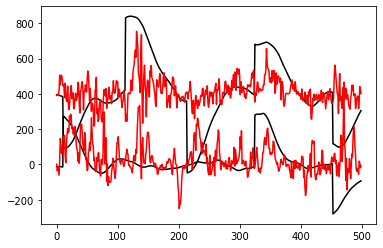

10 Discriminator loss_day_0: 18.373972 \Discriminator loss_day_k: 11.318878
EMG non-aligned VAF: 8.7745 	EMG aligned VAF: -16.3285 	EMG aligned r:  0.1108632772655281


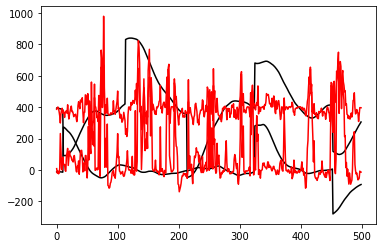

KeyboardInterrupt: 

In [7]:
#day0, dayk = test_ADAN(arg)
scores_dict = test_ADAN(arg, model_folder)